In [38]:
#installation des packages nécéssaires

!pip install langdetect 
!pip install langdetect 
!pip install wordcloud
!pip install nltk
!pip install  gensim
!pip install vaderSentiment
!pip install textblob
!pip install vaderSentiment-fr
!pip install deep-translator

In [39]:
#importation des packages nécessaires

import pandas as pd
import numpy as np
from langdetect import detect # pour detecter les langues
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud # pour gerer les nuages de mots

from deep_translator import GoogleTranslator 

#from collections import Counter

#stopword français
import nltk
from nltk.corpus import stopwords 
nltk.download('stopwords') 

# stopword anglais
import gensim 
from gensim.parsing.preprocessing import STOPWORDS 


#from gensim import corpora

from PIL import Image # pour personaliser la forme du wordcloud

# pour analyser les sentiments
nltk.download('punkt')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SenEN
analyzer = SenEN()



[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [40]:
#chargement de la base de donnée depuis Github
df=pd.read_csv("https://github.com/Serinem/Projet-Python-pour-le-data-scientist/blob/main/Commentaires.csv?raw=true",sep=";",encoding="latin_1")
df.head()


,Unnamed: 0,Comments
0,cn31512,"Tout neuf, des plus et des moins. Parmi les mo..."
1,cn31105,"Livraison ok, ordinateur super"
2,cn31105,Toujours parfait. Merci de cet envoi rapide
3,cn31105,bel ordinateur et correspond à nos attentes. t...
4,cn31105,PC de qualité et solide..


# Detection des langues

In [42]:
def langue(text):
    try:
        return detect(text)
    except:
        return None

In [43]:
df['langues']=df['Comments'].apply(langue)
print(f"il n'ya {len(df.langues.unique())} langues trouvées")
df['langues'].value_counts()

il n'ya 5 langues trouvées


fr    1822
en      31
ca      11
ro       9
af       6
Name: langues, dtype: int64

Comme on peut le constater , les commentaires sont rédigés dans 6 langues et la majorité est  en Français.
Nous pouvons mieux visualiser à l'aide du graphique ci-dessous.

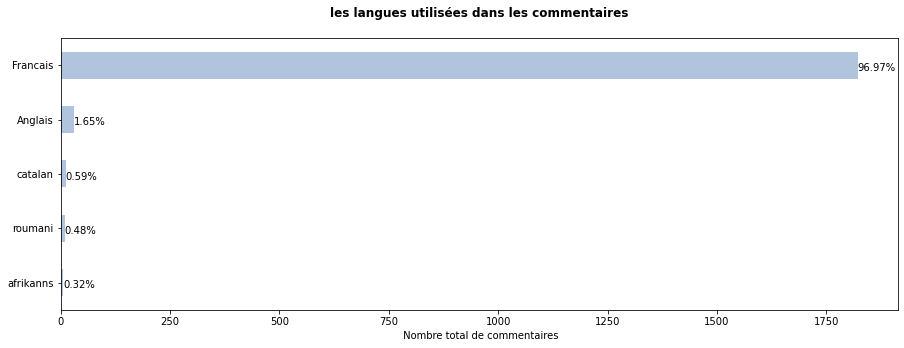

In [45]:
ax=df['langues'].value_counts().sort_values(ascending=False).plot(kind='barh',figsize=(15,5),color='lightsteelblue')
ax.set_title("les langues utilisées dans les commentaires\n", 
             fontsize=12, fontweight='bold')
ax.set_xlabel(" Nombre total de commentaires", fontsize=10)
ax.set_yticklabels(['Francais','Anglais','catalan', 'roumani','afrikanns'])
totals = []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
    ax.text(x=i.get_width(), y=i.get_y()+.35, 
            s=str(round((i.get_width()/total)*100, 2))+'%', 
            fontsize=10, color='black')
ax.invert_yaxis()

96,97 % des commentaires sont en français ce qui est tout à fait logique vu que nous travaillons sur les laptop DELL France. Les autres langues sont presques négligéables.

Après une analyse minutieuse, on s'est rendu compte qu'en réalité les commentaires sont rédigés seulement dans deux langues. les autres langues ne sont juste qu'une erreur de detection.
pour cette raison, dans la suite de notre travail nous allons regrouper les langues en deux catégories  Français et Anglais.

In [46]:
df1=df[df['langues']=='ro']
df2=pd.concat([df1[df1['Unnamed: 0']=="cn51209sc11"],df1[df1['Unnamed: 0']=="cn51203sc"],df1[df1['Unnamed: 0']=="cn51210sc11"]],axis=0)
df3=df1.drop(df1.loc[df1["Unnamed: 0"].isin(["cn51209sc11","cn51203sc","cn51210sc11"]),].index)

df_english=pd.concat([df[df['langues']=='en'],df3],axis=0)
df_french=pd.concat([df[df['langues']=='fr'],df[df['langues']=='af'],df[df['langues']=='ca'],df[df['langues']=='es'],df2],axis=0)


# Visualisation des données avec les WordClouds.

Ici il s'agit de representer graphiquement les mots qui reviennent le plus dans les commentaires. Pour ce faire, nous allons commencer par définir les Stop-words : Il s'agit des mots qui ne nous seront pas utiles pour les analyses.

# Définition des Stop-words

Le package gensim nous a fourni les Stop-words anglais et les stop-words francais proviennent du package nltk. Ces derniers ont été enrichis par d'autres stop-words que nous avons défini.

In [47]:
stop_word_en = STOPWORDS
stop_word_fr = set(stopwords.words('french'))
stop_words_add_fr=['téléphone', 'farantieEt','PC','a', 'portable', 'logicielUne', 'une', 'reception','Livraison','internet','portables','respectés','contrôler','command','ordi','possibilité','moins','plus','cause','option','client','envoie','touchpad','option','parmi','seul','neuf','dirais','d', 'du', 'de', 'la', 'des', 'le', 'et', 'est', 'elle', 'une', 'en', 'que', 'aux', 'qui', 'ces', 'les', 'dans', 'sur', 'l', 'un', 'pour', 'par', 'résolus','esim','tres','voir','ok','gamme','fois', 'livraisons','Bref', 'reste','après','temps','première','connection','remboursement', 'bref','délais','soucis','souris','tout','versions','trop', 'mette','réception',  'affichage', 'recommande', 'commande', 'toujours', 'sont', 'cas', 'plus', 'leur', 'se', 's', 'vous', 'au', 'c', 'aussi', 'toutes', 'autre', 'comme','service','marché','seule','rapport','haute','depuis','technique','arrivé','center','année','puis',"d'autres",'non','cet','plusieurs',"l'ordinateur",'envoi','ordinateur']
stop_word_fr.update(stop_words_add_fr)

# Construction du WordCloud

In [53]:
def plot_wordcloud(df, langue,stop_word):
    wordcloud=WordCloud(max_font_size=None, max_words=500, background_color="white",stopwords=stop_word, random_state=42, width=500, height=500).generate(str(df.values))
    plt.imshow(wordcloud,interpolation = 'bilinear')
    plt.axis("off")
    plt.title(langue + ' Comments\n', fontsize=25, fontweight='bold')
    plt.show()

#  WordCloud des commentaires en francais

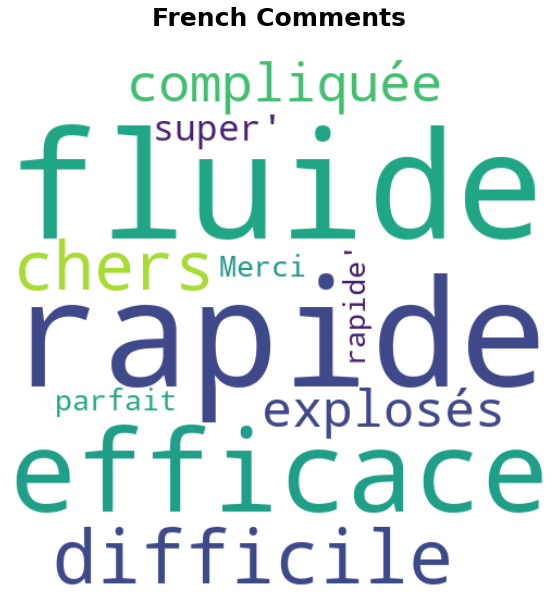

In [54]:
plt.figure(figsize=(12, 10))
plot_wordcloud(df_french['Comments'], "French",stop_word_fr)
plt.show()

# WordCloud des commentaires en Anglais

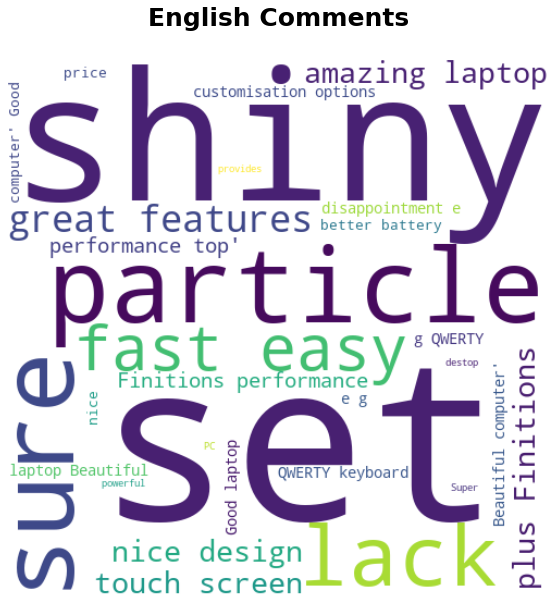

In [55]:
plt.figure(figsize=(12, 10))
plot_wordcloud(df_english['Comments'], "English",stop_word_en)
plt.show()

# Analyse sentimentale des commentaires

L’analyse des sentiments consiste essentiellement à juger le sentiment qui se cache derrière un écrit. Le processus consiste donc à prendre un morceau de texte, qu’il s’agisse d’une phrase ou d’un article complet, et à analyser l’émotion que l’auteur exprime. Dans notre analyse, nous allons calculer pour chaque commentaire, le score de sentiment positif, négatif ou neutre qu'il exprime. Nous allons par la suite classer chaque commentaire en fonction du sentiment positif, négatif ou neutre.

# Score  de sentiment pour les commentaires en Français

In [56]:
df_french['negatif_feeling'] = df_french['Comments'].apply(lambda x:analyzer.polarity_scores(x)['neg'])
df_french['neutral_feeling'] = df_french['Comments'].apply(lambda x:analyzer.polarity_scores(x)['neu'])
df_french['positif_feeling'] = df_french['Comments'].apply(lambda x:analyzer.polarity_scores(x)['pos'])
df_french['compound_feeling'] = df_french['Comments'].apply(lambda x:analyzer.polarity_scores(x)['compound'])
df_french.head()

,Unnamed: 0,Comments,langues,negatif_feeling,neutral_feeling,positif_feeling,compound_feeling
0,cn31512,"Tout neuf, des plus et des moins. Parmi les mo...",fr,0.028,0.972,0.000,-0.1280
1,cn31105,"Livraison ok, ordinateur super",fr,0.000,0.247,0.753,0.7269
2,cn31105,Toujours parfait. Merci de cet envoi rapide,fr,0.000,1.000,0.000,0.0000
3,cn31105,bel ordinateur et correspond à nos attentes. t...,fr,0.000,1.000,0.000,0.0000
4,cn31105,PC de qualité et solide..,fr,0.000,1.000,0.000,0.0000


#  Score de sentiment pour les commentaires en Anglais

In [57]:
df_english['negatif_feeling'] = df_english['Comments'].apply(lambda x:analyzer.polarity_scores(x)['neg'])
df_english['neutral_feeling'] = df_english['Comments'].apply(lambda x:analyzer.polarity_scores(x)['neu'])
df_english['positif_feeling'] = df_english['Comments'].apply(lambda x:analyzer.polarity_scores(x)['pos'])
df_english['compound_feeling'] = df_english['Comments'].apply(lambda x:analyzer.polarity_scores(x)['compound'])
df_english.head()

,Unnamed: 0,Comments,langues,negatif_feeling,neutral_feeling,positif_feeling,compound_feeling
721,cn93209sc,"fast, easy to set up, great features and shiny!",en,0.000,0.490,0.510,0.8070
761,cn93209sc,"It's an amazing laptop, really particle and ha...",en,0.000,0.611,0.389,0.8360
778,cn93209sc,Finitions performance top,en,0.000,0.526,0.474,0.2023
813,cn93209sc,The lack of customisation options is such a di...,en,0.384,0.616,0.000,-0.6808
864,cn93242sc11,"fast, easy to set up, great features and shiny!",en,0.000,0.490,0.510,0.8070


La bibliothèque VADER renvoie 4 valeurs telles que :

**pos**: La probabilité que le sentiment soit positif

**neu**: La probabilité que le sentiment soit neutre

**neg**: La probabilité que le sentiment soit négatif

**compound**: Le score composé normalisé qui calcule la somme de toutes les cotes du lexique et prend des valeurs de -1 à 1

Dans la suite,nous ferons une concaténation des bases des commentaires/scores en francais et en englais pour former une base unique afin d'afficher l'histogramme des scores

In [58]:
# scores  pour l'anglais et francais
base=pd.concat([df_french,df_english])

# Histogramme selon la nature du score

In [60]:
def histogram(df):
    fig, axes = plt.subplots(2, 2, figsize=(10,8))
    df.hist('negatif_feeling', bins=25, ax=axes[0,0], color='lightcoral', alpha=0.6)
    axes[0,0].set_title('Negative Sentiment Score')
    df.hist('neutral_feeling', bins=25, ax=axes[0,1], color='lightsteelblue', alpha=0.6)
    axes[0,1].set_title('Neutral Sentiment Score')
    df.hist('positif_feeling', bins=25, ax=axes[1,0], color='chartreuse', alpha=0.6)
    axes[1,0].set_title('Positive Sentiment Score')
    df.hist('compound_feeling', bins=25, ax=axes[1,1], color='navajowhite', alpha=0.6)
    axes[1,1].set_title('Compound')
    fig.text(0.5, 0.04, 'Scores de sentiment',  fontweight='bold', ha='center')
    fig.text(0.04, 0.5, 'Nombre de commentaires', fontweight='bold', va='center', rotation='vertical')
    plt.suptitle('Analyse sentimentale des utilisateurs des laptops Dell France \n\n', fontsize=12, fontweight='bold');

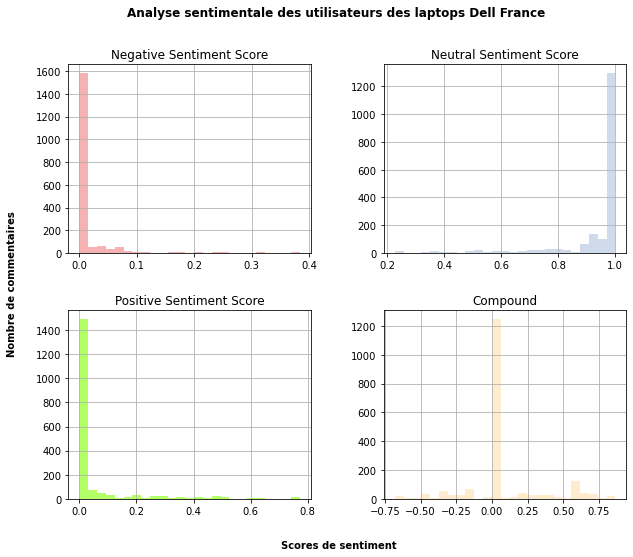

In [61]:
histogram(base)

commentaires

detection pb et methode de resolution

# Traduction des commentaires en Anglais

In [67]:
%%time
data=df.rename({'Sans nom : 0':'N°Commande'},axis=1)
data['Comment']=base['Comments'].apply(lambda x:GoogleTranslator(source='auto', target='en').translate(x))
data

CPU times: user 53.7 s, sys: 2.36 s, total: 56.1 s
Wall time: 6min 9s


,Unnamed: 0,Comments,langues,Comment
0,cn31512,"Tout neuf, des plus et des moins. Parmi les mo...",fr,"Brand new, pluses and minuses. Among the minus..."
1,cn31105,"Livraison ok, ordinateur super",fr,"Delivery ok, computer great"
2,cn31105,Toujours parfait. Merci de cet envoi rapide,fr,Always perfect. Thank you for this quick shipment
3,cn31105,bel ordinateur et correspond à nos attentes. t...,fr,beautiful computer and meets our expectations....
4,cn31105,PC de qualité et solide..,fr,Quality and solid PC.
...,...,...,...,...
1874,nawx17r108,Je lai commande une première fois il est arri...,fr,I ordered it the first time it arrived faulty ...
1875,nawx17r108,Les températures sont très correctes pour un p...,fr,The temperatures are very correct for such a p...
1876,nawx17r108,"haute gamme, tres puissant, le plus puissant d...",fr,"high range, very powerful, the most powerful i..."
1877,nawx17r108,Je lai commande une première fois il est arri...,fr,I ordered it the first time it arrived faulty ...


# Score de sentiment

In [68]:
data['negatif_feeling'] = data['Comment'].apply(lambda x:analyzer.polarity_scores(x)['neg'])
data['neutral_feeling'] = data['Comment'].apply(lambda x:analyzer.polarity_scores(x)['neu'])
data['positif_feeling'] = data['Comment'].apply(lambda x:analyzer.polarity_scores(x)['pos'])
data['compound_feeling'] = data['Comment'].apply(lambda x:analyzer.polarity_scores(x)['compound'])
data.head()

,Unnamed: 0,Comments,langues,Comment,negatif_feeling,neutral_feeling,positif_feeling,compound_feeling
0,cn31512,"Tout neuf, des plus et des moins. Parmi les mo...",fr,"Brand new, pluses and minuses. Among the minus...",0.127,0.873,0.000,-0.7394
1,cn31105,"Livraison ok, ordinateur super",fr,"Delivery ok, computer great",0.000,0.241,0.759,0.7430
2,cn31105,Toujours parfait. Merci de cet envoi rapide,fr,Always perfect. Thank you for this quick shipment,0.000,0.492,0.508,0.7351
3,cn31105,bel ordinateur et correspond à nos attentes. t...,fr,beautiful computer and meets our expectations....,0.000,0.719,0.281,0.5994
4,cn31105,PC de qualité et solide..,fr,Quality and solid PC.,0.000,0.652,0.348,0.1531


# Histogramme selon la nature de score

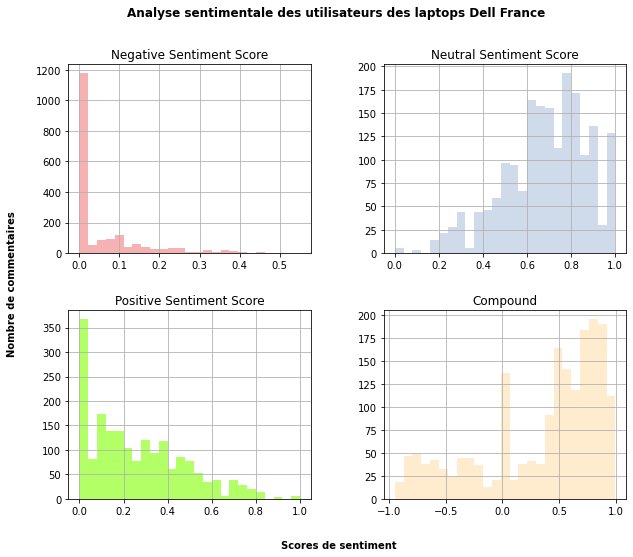

In [69]:
histogram(data)

commentaires

Le score est une mesure très utile du sentiment. Les valeurs seuils typiques sont les suivantes:

positif: score composé>=0,05 neutre: score composé entre -0,05 et 0,05 négatif: score composé<=-0,05

# Classification des commentaires selon la norme çi dessus

In [71]:
def verification(number):
    if number<-0.05 :
        return 'négatif'
    elif number<=0.05 :
        return 'neutre'
    else:
        return 'positif'

In [72]:
data['Nature_feeling'] = data['compound_feeling'].apply(lambda x:verification(x))
data.head(10)

,Unnamed: 0,Comments,langues,Comment,negatif_feeling,neutral_feeling,positif_feeling,compound_feeling,Nature_feeling
0,cn31512,"Tout neuf, des plus et des moins. Parmi les mo...",fr,"Brand new, pluses and minuses. Among the minus...",0.127,0.873,0.000,-0.7394,négatif
1,cn31105,"Livraison ok, ordinateur super",fr,"Delivery ok, computer great",0.000,0.241,0.759,0.7430,positif
2,cn31105,Toujours parfait. Merci de cet envoi rapide,fr,Always perfect. Thank you for this quick shipment,0.000,0.492,0.508,0.7351,positif
3,cn31105,bel ordinateur et correspond à nos attentes. t...,fr,beautiful computer and meets our expectations....,0.000,0.719,0.281,0.5994,positif
4,cn31105,PC de qualité et solide..,fr,Quality and solid PC.,0.000,0.652,0.348,0.1531,positif
5,cn31105,"Ordi pour du bureau, vraiment. Même un petit j...",fr,"Computer for the office, really. Even a small ...",0.000,0.829,0.171,0.7506,positif
6,cn31105,Qualité de limage très médiocre pour un ordin...,fr,Very poor picture quality for a computer of th...,0.361,0.639,0.000,-0.7774,négatif
7,cn31105,Ordinateur de très bonne qualité. Cependant le...,fr,Very good quality computer. However the big we...,0.072,0.848,0.080,0.0754,positif
8,cn31105,Machine fragile. La régulation de température ...,fr,Fragile machine. The temperature control does ...,0.185,0.815,0.000,-0.2057,négatif
9,cn31105,PAS SATISFAIT DU TOUT DE CET ACHAT ! Jai Ache...,fr,NOT SATISFIED AT ALL WITH THIS PURCHASE! I bou...,0.230,0.770,0.000,-0.9471,négatif


In [73]:
data.loc[(data['compound_feeling']>=-0.05)&(data['compound_feeling']<=0.05),].head()

,Unnamed: 0,Comments,langues,Comment,negatif_feeling,neutral_feeling,positif_feeling,compound_feeling,Nature_feeling
43,cn51107sc11,"Bonjour, Afficher l'avis complet Cette action...",fr,"Bonjour,… View full review This action will op...",0.0,1.0,0.0,0.0,neutre
52,cn51106sc11,"Bonjour, Afficher l'avis complet Cette action...",fr,"Bonjour,… View full review This action will op...",0.0,1.0,0.0,0.0,neutre
83,cn51525sc11,Portable répondant à mes besoins,fr,Laptop meeting my needs,0.0,1.0,0.0,0.0,neutre
87,cn51525sc11,Impeccable.................,ca,Impeccable.................,0.0,1.0,0.0,0.0,neutre
110,cn51525sc11,Produits compacts et léger,fr,Compact and lightweight products,0.0,1.0,0.0,0.0,neutre


In [74]:
data['Nature_feeling'].value_counts()

positif    1336
négatif     404
neutre      139
Name: Nature_feeling, dtype: int64

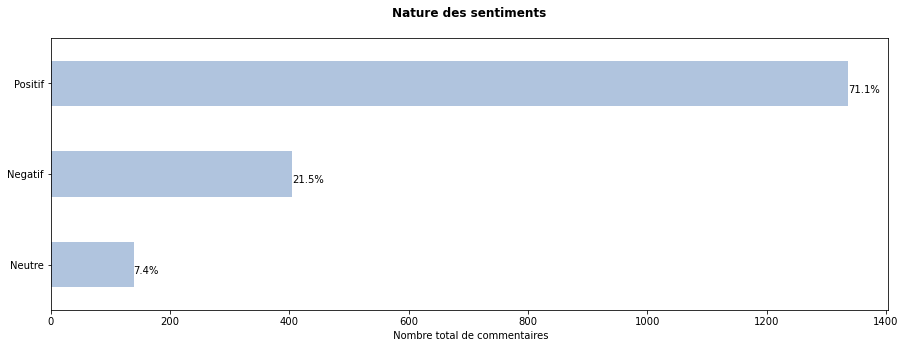

In [75]:
axe=data['Nature_feeling'].value_counts().sort_values(ascending=False).plot(kind='barh',figsize=(15,5),color='lightsteelblue')
axe.set_title("Nature des sentiments\n", 
             fontsize=12, fontweight='bold')
axe.set_xlabel(" Nombre total de commentaires", fontsize=10)
axe.set_yticklabels(['Positif','Negatif','Neutre'])
totals = []
for i in axe.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in axe.patches:
    axe.text(x=i.get_width(), y=i.get_y()+.35, 
            s=str(round((i.get_width()/total)*100, 2))+'%', 
            fontsize=10, color='black')
axe.invert_yaxis()

In [76]:
def Comparaison(df): 
    prop=data["Nature_feeling"].value_counts(normalize=True).tolist()
    neg =prop[2]*100
    mid = prop[1]*100
    pos = prop[0]*100
    names = ['commentaires neutres', 'commentaires négatifs','commentaires positifs']
    size = [neg, mid, pos]
    plt.pie(size, labels=names, colors=['lightcoral', 'lightsteelblue', 'chartreuse'], 
            autopct='%.2f%%', pctdistance=0.8,
            wedgeprops={'linewidth':7, 'edgecolor':'white' })
    my_circle = plt.Circle((0,0), 0.6, color='white')
    fig = plt.gcf()
    fig.set_size_inches(7,7)
    fig.gca().add_artist(my_circle)
    plt.show()

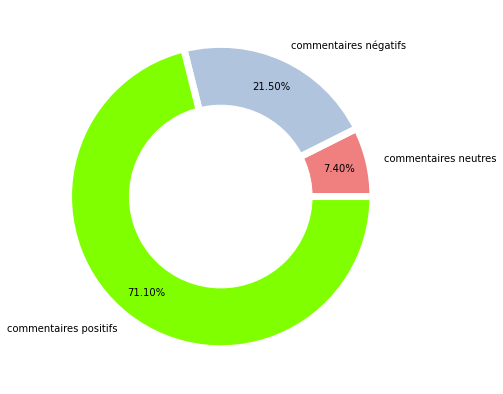

In [77]:
Comparaison(data)